In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import iris

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from IPython.display import Markdown as md
from plot_4p4 import extract_vortex_info, plot_t_bright_himawari
from func_4p4 import open_file

import matplotlib
%matplotlib inline
from matplotlib.patches import Rectangle
import cmocean

In [43]:
# plot characteristics 
lon_start = 93.0 # 88.0
lon_end = 123.0 # 130.0
lat_start = -3.0 # -6.0
lat_end = 20.0 # 23.0

bounds = [lon_start, lon_end, lat_start, lat_end]

Tp = 48
time = int(Tp-12)

In [44]:
# read in new N768 MetUM data (12-h accumulated precip)
prcp_data_path = '/nobackup/earshar/borneo/case_20181021T1200Z_N768_v2/umglaa_pa{0:03d}.nc'.format(time)
wind_data_path = '/nobackup/earshar/borneo/case_20181021T1200Z_N768_v2/umglaa_pe{0:03d}.nc'.format(time)

In [45]:
# read in 4p4 MetUM data 
data_path_4p4 = '/nobackup/earshar/borneo/20181021T1200Z_SEA4_km4p4_ra1tld'
_, date_str, _, _, _ = open_file(data_path_4p4, Tp, file_type='4p4')

In [46]:
# process 4p4 MetUM data and extract 12-h accumulated precipitation 
data_path_4p4 = '{0}_pverb.pp'.format(data_path_4p4)
pcubes = iris.load(data_path_4p4)
prcp_4p4_data = xr.DataArray.from_iris(pcubes.extract('stratiform_rainfall_flux')[1])

In [47]:
# subset and extract 12-h accumulated precipitation 
prcp_4p4_data = prcp_4p4_data.sel(longitude=slice(bounds[0], bounds[1]), latitude=slice(bounds[2], bounds[3]))
prcp_4p4_data = prcp_4p4_data * 3600. 
prcp_4p4_data = prcp_4p4_data.resample(time="12H").sum().sel(time = slice('2018-10-21T12', '2018-10-26T12') )

In [48]:
# vortex track + intensity data 
vortex_path = '/nobackup/earshar/borneo/bv_2018102112_track.csv'
bv_lat, bv_lon, bv_time = extract_vortex_info(vortex_path)

In [49]:
# read in Himawari data 
single_date_str = date_str.strftime("%Y%m%d_%H00")
himawari_path = '/nobackup/earshar/borneo/himawari/himawari_10.4_{0}.nc'.format(single_date_str)

In [9]:
# read in GPM data 
gpm_path = '/nobackup/earshar/borneo/GPMHH_201810.nc'
gpm_data = xr.open_dataset(gpm_path).sel(lon=slice(bounds[0], bounds[1]), lat=slice(bounds[2], bounds[3]))
prcp_gpm = gpm_data.precipitationCal

In [10]:
# resample GPM data to calculate 12-h accumulated precipitation
prcp_gpm_12h = prcp_gpm.resample(time="12H").sum().sel(time=slice('2018-10-21T12', '2018-10-26T12'))

In [4]:
# START FROM HERE 
# Convert to nc: DONE 
# Open and plot: DONE
# Customise plot: DONE
# Overlay vortex box position: DONE
# Make sure other files are still on ARC (4p4, GPM, Himawari): DONE
# Replot accumulated precipitation for N768 MetUM + Himawari (Figs. 3c,d + 4c,d): DONE
# Replot accumulated precipitation for 4p4 MetUM + GPM (Figs. 3a,b + 4a,b): TODO
# Replot time-series figure (Figure 5; also requires relative vorticity --> pe stream): TODO

In [11]:
# open N768 MetUM data
prcp_data = xr.open_dataset(prcp_data_path)
wind_data = xr.open_dataset(wind_data_path)

In [12]:
# process precipitation data 
prcp_sub = prcp_data.squeeze('surface').sel(longitude=slice(lon_start, lon_end),
                                            latitude=slice(lat_start, lat_end))
prcp_n768 = prcp_sub['tot_precip'].squeeze('t_1')

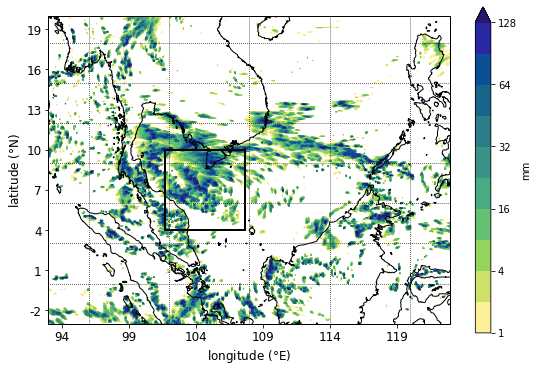

In [13]:
# 4p4 MetUM plot (Figs. 3a + 4a)

fig, ax = plt.subplots(figsize=(9, 6), subplot_kw={'projection': ccrs.PlateCarree()})
# domain extent
ax.set_extent([lon_start, lon_end, lat_start, lat_end], ccrs.PlateCarree())
# gridlines
ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.75, color='k', linestyle=':')
# customise further 
Levels=[1.0, 2.0, 4.0, 8.0, 16.0, 24.0, 32.0, 48.0, 64.0, 96.0, 128.0]

# plot data 
prcp_4p4 = prcp_4p4_data.sel(time='2018-10-24T00')
prcp_4p4.plot.contourf(ax=ax, levels=Levels, extend='max', 
                        transform=ccrs.PlateCarree(),
                        cbar_kwargs={'label': 'mm'},
                        cmap=cmocean.cm.haline_r)

# customise plot
ax.coastlines(resolution='10m', color='k', linewidth=1)
ax.set_xticks([94, 99, 104, 109, 114, 119])
ax.set_yticks([-2, 1, 4, 7, 10, 13, 16, 19])
ax.set_xticklabels([94, 99, 104, 109, 114, 119], fontsize='large')
ax.set_yticklabels([-2, 1, 4, 7, 10, 13, 16, 19], fontsize='large')
ax.set_xlabel(r'longitude ($\degree$E)', fontsize='large')
ax.set_ylabel(r'latitude ($\degree$N)', fontsize='large')
ax.set_title('')

# overlay BV box position 
r0 = 3.0
ax.add_patch( Rectangle( (bv_lon[12]-r0, bv_lat[12]-r0),
                            2*r0, 2*r0, linewidth=2,
                            facecolor='none', edgecolor='k') )

In [14]:
fig.savefig('fig4a_new.png')

In [35]:
# pre-process GPM data
# (1) calculate 12-h accumulated precip, (2) interpolate onto 4p4 MetUM grid, (3) transpose
prcp_gpm = prcp_gpm_12h.sel(time='2018-10-24T12').squeeze('time')

prcp_gpm_plot = prcp_gpm.interp(lon=prcp_4p4["longitude"],
                                lat=prcp_4p4["latitude"],
                                method="linear")

prcp_gpm_plot = prcp_gpm_plot.transpose('latitude', 'longitude')

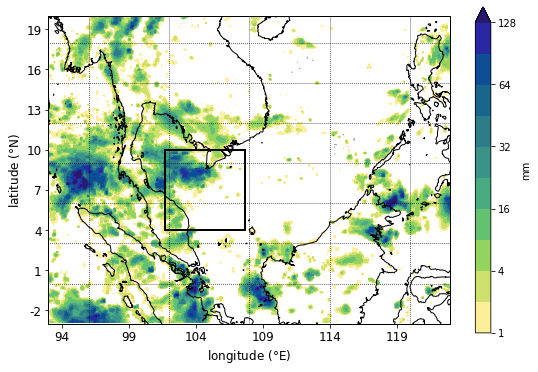

In [37]:
# GPM plot (Figs. 3b + 4b)

fig, ax = plt.subplots(figsize=(9, 6), subplot_kw={'projection': ccrs.PlateCarree()})
# domain extent
ax.set_extent([lon_start, lon_end, lat_start, lat_end], ccrs.PlateCarree())
# gridlines
ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.75, color='k', linestyle=':')
# customise further 
Levels=[1.0, 2.0, 4.0, 8.0, 16.0, 24.0, 32.0, 48.0, 64.0, 96.0, 128.0]

# plot data 
prcp_gpm_plot.plot.contourf(ax=ax, levels=Levels, extend='max', 
                        transform=ccrs.PlateCarree(),
                        cbar_kwargs={'label': 'mm'},
                        cmap=cmocean.cm.haline_r)

# customise plot
ax.coastlines(resolution='10m', color='k', linewidth=1)
ax.set_xticks([94, 99, 104, 109, 114, 119])
ax.set_yticks([-2, 1, 4, 7, 10, 13, 16, 19])
ax.set_xticklabels([94, 99, 104, 109, 114, 119], fontsize='large')
ax.set_yticklabels([-2, 1, 4, 7, 10, 13, 16, 19], fontsize='large')
ax.set_xlabel(r'longitude ($\degree$E)', fontsize='large')
ax.set_ylabel(r'latitude ($\degree$N)', fontsize='large')
ax.set_title('')

# overlay BV box position 
r0 = 3.0
ax.add_patch( Rectangle( (bv_lon[12]-r0, bv_lat[12]-r0),
                            2*r0, 2*r0, linewidth=2,
                            facecolor='none', edgecolor='k') )

In [38]:
fig.savefig('fig4b_alt_new.png')

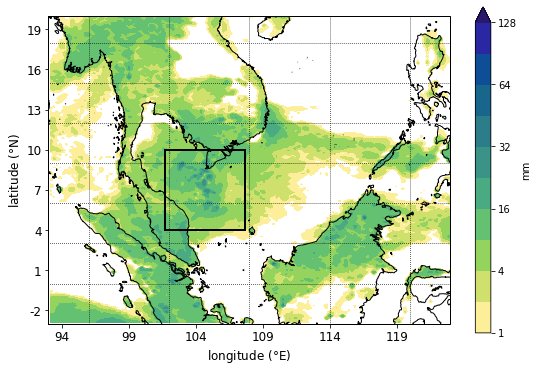

In [39]:
# N768 MetUM plot (Figs. 3c + 4c)

fig, ax = plt.subplots(figsize=(9, 6), subplot_kw={'projection': ccrs.PlateCarree()})
# domain extent
ax.set_extent([lon_start, lon_end, lat_start, lat_end], ccrs.PlateCarree())
# gridlines
ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.75, color='k', linestyle=':')
# customise further 
Levels=[1.0, 2.0, 4.0, 8.0, 16.0, 24.0, 32.0, 48.0, 64.0, 96.0, 128.0]

# plot data 
prcp_n768.plot.contourf(ax=ax, levels=Levels, extend='max', 
                        transform=ccrs.PlateCarree(),
                        cbar_kwargs={'label': 'mm'},
                        cmap=cmocean.cm.haline_r)

# customise plot
ax.coastlines(resolution='10m', color='k', linewidth=1)
ax.set_xticks([94, 99, 104, 109, 114, 119])
ax.set_yticks([-2, 1, 4, 7, 10, 13, 16, 19])
ax.set_xticklabels([94, 99, 104, 109, 114, 119], fontsize='large')
ax.set_yticklabels([-2, 1, 4, 7, 10, 13, 16, 19], fontsize='large')
ax.set_xlabel(r'longitude ($\degree$E)', fontsize='large')
ax.set_ylabel(r'latitude ($\degree$N)', fontsize='large')
ax.set_title('')

# overlay BV box position 
r0 = 3.0
ax.add_patch( Rectangle( (bv_lon[12]-r0, bv_lat[12]-r0),
                            2*r0, 2*r0, linewidth=2,
                            facecolor='none', edgecolor='k') )

In [40]:
fig.savefig('fig4c_new.png')

In [50]:
# process Himawari data 
himawari_data = xr.open_dataset(himawari_path).metpy.parse_cf()

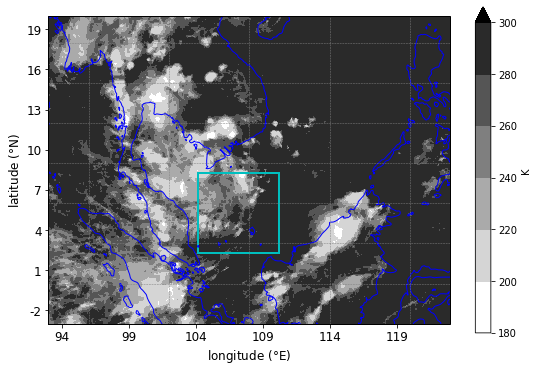

In [52]:
# produce Himawari plot (Figs. 3d + 4d)

fig, ax = plt.subplots(figsize=(9, 6), subplot_kw={'projection': ccrs.PlateCarree()})
# domain extent
ax.set_extent([lon_start, lon_end, lat_start, lat_end], ccrs.PlateCarree())
# gridlines
plt.gca().gridlines(color='grey', linestyle='--', linewidth=0.5)
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), edgecolor='blue', linewidth=1.0)

# plot data 
Levels=[180, 200, 220, 240, 260, 280, 300]
t_bright = himawari_data.T_b
t_bright.plot.contourf(ax=ax, levels=Levels, extend='max', transform=ccrs.PlateCarree(),
                        cbar_kwargs={'label': 'K'},
                        cmap='gist_yarg')

# customise plot      
ax.set_xticks([94, 99, 104, 109, 114, 119])
ax.set_yticks([-2, 1, 4, 7, 10, 13, 16, 19])
ax.set_xticklabels([94, 99, 104, 109, 114, 119], fontsize='large')
ax.set_yticklabels([-2, 1, 4, 7, 10, 13, 16, 19], fontsize='large')
ax.set_xlabel(r'longitude ($\degree$E)', fontsize='large')
ax.set_ylabel(r'latitude ($\degree$N)', fontsize='large')
ax.set_title('')

# overlay BV box position 
r0 = 3.0
ax.add_patch( Rectangle( (bv_lon[8]-r0, bv_lat[8]-r0),
                            2*r0, 2*r0, linewidth=2,
                            facecolor='none', edgecolor='c') )

In [53]:
fig.savefig('fig3d_new.png')